In [35]:
#import os
#jdbcPathUbuntu = '/usr/share/java/postgresql-42.2.23.jar'
#jdbcPathMacOS = '/Users/cristianomartinsm/postgresql-42.2.23.jar'
#jdbcPath = jdbcPathUbuntu
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-class-path ' + jdbcPath + ' --jars ' + jdbcPath + ' pyspark-shell'
#import databricks.koalas as ks
import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas as pd
from scipy import stats
import numpy as np
import json
from pathlib import Path
from datetime import datetime, timedelta
from collections import OrderedDict

In [36]:
kmLimit = 4000
folderData = 'Optimal Solutions/Free Floating/' + str(kmLimit) + '/'

dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        multiplierRounded = round(pricesMultiplier, 1)
        percentagePrice = int(multiplierRounded*100)
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                dataList.append((multiplierRounded, distanceCutOff, 4*float(optimalSolution["SolutionInfo"]["ObjVal"])))
        except FileNotFoundError:
            break

#dataFramePd = dataFrame.to_pandas()
dataFramePd = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'profit'])
dataFramePd = dataFramePd.pivot(index='multiplier', columns='distance', values='profit')
#dataFrame['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


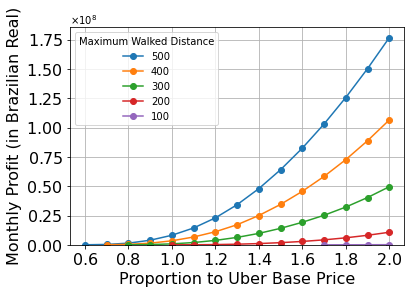

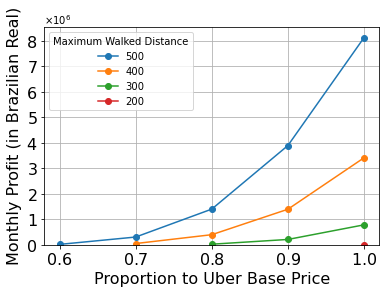

In [37]:
def formatFloat(value):
    numDecimaPlaces = 4
    return " & " + "{:.{nDigits}f}".format(value, nDigits=numDecimaPlaces)

def prepareLinePlot(dataFrame, xLabel, yLabel, legendTitle, fileName, xTicks=None, yTicks=None, yLim=[0, None], tickFormat=None):
    #Showing legend items backwards. Reindexing is better than sorting the legend_handles because it maintains the color order.
    dataFrame = dataFrame.reindex(columns=sorted(dataFrame.columns, reverse=True))

    ax = dataFrame.plot.line(fontsize=16, grid=True, marker='o')
    ax.legend(title=legendTitle)
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(reversed(handles), reversed(labels)).set_title(legendTitle)

    ax.set_xlabel(xLabel, fontsize=16)
    ax.set_ylabel(yLabel, fontsize=16)

    ax.set_ylim(yLim)

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)

    if tickFormat == 'plain':
        ax.ticklabel_format(useOffset=False, style='plain')
    else:
        ax.ticklabel_format(scilimits=(-5, 3), useMathText=True)
    
    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

folderSave = Path('./IEEE T-ITS/' + str(kmLimit))
folderSave.mkdir(parents=True, exist_ok=True)

#PROFIT GRAPHS
fileName = folderSave / 'Profits.eps'
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Monthly Profit (in Brazilian Real)",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve())

lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
fileName = folderSave / 'Profits_until_1.eps'
minPercentage = min(smallerDataFrame.index)
maxValueAmongAllColumns = max(smallerDataFrame.max())
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Monthly Profit (in Brazilian Real)",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5),
                        yTicks=np.arange(0, maxValueAmongAllColumns, pow(10, 6)))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


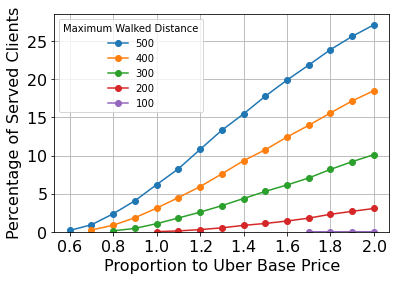

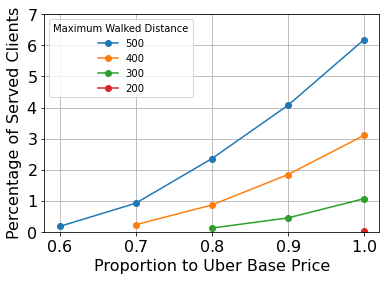

In [38]:
#SERVED CLIENTS GRAPH
def loadMaxAmountTrips():
    params = {'host':'localhost', 'port':'5432', 'database':'afterqualifying', 'user':'cristiano', 'password':'cristiano'}
    conn = pg.connect(**params)
    cur = conn.cursor()

    sqlQuery = '''	select	sum(floor(TRIP.TRIPEXPANSIONFACTOR))
                    from	TRIP;
                    '''
    cur.execute(sqlQuery)
    maxAmountTrips = cur.fetchone()[0]
    cur.close()
    conn.close()

    return maxAmountTrips

def loadTrips():
    params = {'host':'localhost', 'port':'5432', 'database':'afterqualifying', 'user':'cristiano', 'password':'cristiano'}
    conn = pg.connect(**params)

    sqlQuery = '''	select	TRIP.IDTRIP,
                            TRIP.TRIPEXPANSIONFACTOR,
                            TRIP.MAINMODE,
                            TRIP.DRIVINGDISTANCE,
                            TRIP.DRIVINGDURATION,
                            TRIP.TIMESTAMPDEPARTURE,
                            TRIP.TIMESTAMPARRIVAL,
                            TRIP.REASONDEPARTURE,
                            TRIP.REASONDESTINATION
                    from	TRIP
                    where   TRIP.DRIVINGDISTANCE > 500
                    '''
    dataFrameEdges = pd.read_sql_query(sqlQuery, conn)
    conn.close()

    trips = dict()
    for row in dataFrameEdges.itertuples():
        dictRow = row._asdict()
        trip = Trip(idTrip=dictRow['idtrip'],
                    expansionFactor=dictRow['tripexpansionfactor'],
                    mainMode=dictRow['mainmode'],
                    drivenDistance=dictRow['drivingdistance'],
                    drivenDuration=dictRow['drivingduration'],
                    timestampDeparture=dictRow['timestampdeparture'],
                    timestampArrival=dictRow['timestamparrival'],
                    departureReason=dictRow['reasondeparture'],
                    destinationReason=dictRow['reasondestination'])
        trips[trip.idTrip] = trip

    return trips

class Trip:
    #Values for defining the new timestamps
    ADJUSTED_MONTH = 1
    ADJUSTED_YEAR = 2017

    amountPeopleMainMode = {}
    amountServedMainMode = {0.7: {},
                            2: {}
    }
    
    amountPeopleDepartureReason = {}
    amountServedDepartureReason = { 0.7: {},
                                    2: {}
    }
    amountPeopleDestinationReason = {}
    amountServedDestinationReason = {   0.7: {},
                                        2: {}
    }

    drivenDistances = { 'all':  [],
                        0.7:    [],
                        2:      []
    }

    def adjustDay(timeDepartureOld, drivingDuration):
        #The weekday() starts from 0 but it does not exist a day 0 in the calendar. Then, a +1 solves this issue
        adjustedDayDeparture = timeDepartureOld.weekday() + 1

        timeDepartureNew = timeDepartureOld.replace(day=adjustedDayDeparture, month=Trip.ADJUSTED_MONTH, year=Trip.ADJUSTED_YEAR)
        timeArrivalNew = timeDepartureNew + timedelta(minutes=drivingDuration)
        
        return timeDepartureNew, timeArrivalNew
    
    def incrementPeople(key, increment, dictToCheck, dictServed):
        if key not in dictToCheck:
            dictToCheck[key] = increment
            dictServed[0.7][key] = 0
            dictServed[2][key] = 0
        else:
            dictToCheck[key] += increment
        
    def __init__(self, idTrip, expansionFactor, mainMode, drivenDistance, drivenDuration, timestampDeparture, timestampArrival, departureReason, destinationReason):
        self.idTrip = idTrip
        self.expansionFactor = expansionFactor
        self.mainMode = mainMode
        self.drivenDistance = drivenDistance
        self.drivenDuration = drivenDuration
        self.timestampDepartureOld = timestampDeparture
        self.timestampArrivalOld = timestampArrival
        self.departureReason = departureReason
        self.destinationReason = destinationReason

        self.timestampDeparture, self.timestampArrival = Trip.adjustDay(timestampDeparture, self.drivenDuration)

        Trip.incrementPeople(self.mainMode, self.expansionFactor, Trip.amountPeopleMainMode, Trip.amountServedMainMode)
        Trip.incrementPeople(self.departureReason, self.expansionFactor, Trip.amountPeopleDepartureReason, Trip.amountServedDepartureReason)
        Trip.incrementPeople(self.destinationReason, self.expansionFactor, Trip.amountPeopleDestinationReason, Trip.amountServedDestinationReason)

        Trip.drivenDistances['all'].append(self.drivenDistance/1000)

maxAmountTrips = loadMaxAmountTrips()
allocatedStations = {}
amountServedTrips = {}
totalDrivenDistance = {}
stationsStart = {   0.7: dict(),
                    2: dict()
}
stationsBalance = { 0.7: list(),
                    2: list()
}
INITIAL_TIMESTAMP = datetime(year=Trip.ADJUSTED_YEAR, month=Trip.ADJUSTED_MONTH, day=1, hour=0, minute=0, second=0)
trips = loadTrips()
dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        percentagePrice = int(round(pricesMultiplier*100, 0))
        multiplierStable = round(pricesMultiplier, 1)

        keyTotalTrips = str(distanceCutOff) + '_' + str(percentagePrice)
        allocatedStations[keyTotalTrips] = 0
        amountServedTrips[keyTotalTrips] = 0
        totalDrivenDistance[keyTotalTrips] = 0
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                for var in optimalSolution["Vars"]:
                    varVTag = var["VTag"][0]
                    varVTagSplit = varVTag.split('_')

                    if varVTag.startswith('station') and varVTag.endswith('start'):
                        amountVehicles = int(var["X"])
                        if amountVehicles > 0:
                            allocatedStations[keyTotalTrips] += amountVehicles

                            if distanceCutOff == 500 and multiplierStable in [0.7, 2]:
                                idStation = int(varVTagSplit[1])
                                stationsStart[multiplierStable][idStation] = amountVehicles
                                stationsBalance[multiplierStable].append((idStation, INITIAL_TIMESTAMP, amountVehicles))

                    elif varVTag.startswith('trip'):
                        idTrip = int(varVTagSplit[1])
                        if varVTag.endswith('filter'):
                            amountServed = int(var["X"])
                            if amountServed > 0:
                                amountServedTrips[keyTotalTrips] += amountServed
                                totalDrivenDistance[keyTotalTrips] += amountServed * trips[idTrip].drivenDistance/1000
                            
                                if distanceCutOff == 500 and (multiplierStable == 0.7 or multiplierStable == 2):
                                    tripMainMode = trips[idTrip].mainMode
                                    tripDepartureReason = trips[idTrip].departureReason
                                    tripDestinationReason = trips[idTrip].departureReason
                                    Trip.amountServedMainMode[multiplierStable][tripMainMode] += amountServed
                                    Trip.amountServedDepartureReason[multiplierStable][tripDepartureReason] += amountServed
                                    Trip.amountServedDestinationReason[multiplierStable][tripDestinationReason] += amountServed

                                    Trip.drivenDistances[multiplierStable].append(trips[idTrip].drivenDistance/1000)

                        elif distanceCutOff == 500 and multiplierStable in [0.7, 2] and varVTagSplit[2] in ['start', 'end']:
                            idStation = int(varVTagSplit[4])
                            vehiclesFlow = int(var["X"])
                            if varVTagSplit[2] == 'start':
                                stationsBalance[multiplierStable].append((idStation, trips[idTrip].timestampDeparture, -1*vehiclesFlow))
                            else:
                                stationsBalance[multiplierStable].append((idStation, trips[idTrip].timestampArrival, vehiclesFlow))

                dataList.append((   pricesMultiplier,
                                    distanceCutOff,
                                    100*amountServedTrips[keyTotalTrips]/maxAmountTrips,
                                    allocatedStations[keyTotalTrips],
                                    4*totalDrivenDistance[keyTotalTrips]/allocatedStations[keyTotalTrips]))
        except FileNotFoundError:
            break

dataFrame = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'served', 'vehicles', 'drivendistance'])
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='served')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

fileName = folderSave / 'Served.eps'
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Percentage of Served Clients",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve())

dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='served')
lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / 'Served_until_1.eps'
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Percentage of Served Clients",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5),
                        yTicks=range(0, 8))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


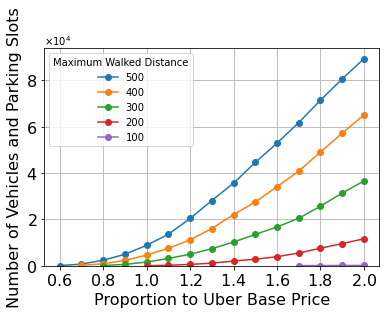

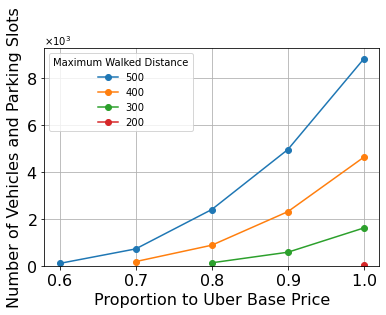

In [39]:
#NUMBER OF VEHICLES
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='vehicles')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

fileName = folderSave / 'Vehicles.eps'
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Number of Vehicles and Parking Slots",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve())

lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
maxValueAmongAllColumns = max(smallerDataFrame.max())
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / 'Vehicles_until_1.eps'
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Number of Vehicles and Parking Slots",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


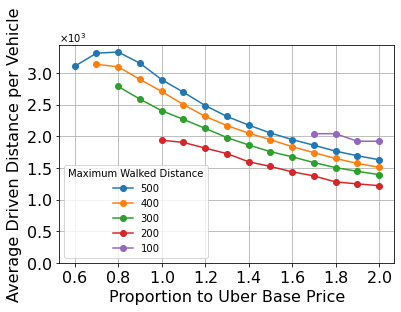

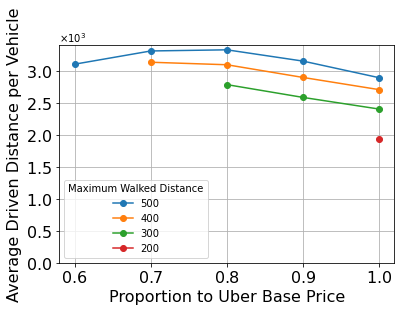

In [40]:
#AVERAGE DRIVEN DISTANCE PER VEHICLE
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='drivendistance')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)

maxValueAmongAllColumns = max(dataFramePd.max())
fileName = folderSave / 'DrivenDistance.eps'
ax = prepareLinePlot(   dataFrame=dataFramePd,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Average Driven Distance per Vehicle",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        yTicks=np.arange(0, maxValueAmongAllColumns, 500))

lastXTick = 1
smallerDataFrame = dataFramePd[dataFramePd.index <= lastXTick].dropna(axis=1, how='all')
minPercentage = min(smallerDataFrame.index)
fileName = folderSave / 'DrivenDistance_until_1.eps'
ax = prepareLinePlot(   dataFrame=smallerDataFrame,
                        xLabel="Proportion to Uber Base Price",
                        yLabel="Average Driven Distance per Vehicle",
                        legendTitle='Maximum Walked Distance',
                        fileName=fileName.resolve(),
                        xTicks=np.linspace(minPercentage, lastXTick, num=5),
                        yTicks=np.arange(0, maxValueAmongAllColumns, 500))

In [41]:
allocatedStations = {}
dataList = list()
for distanceCutOff in np.linspace(100, 500, num=5, dtype=int):
    for pricesMultiplier in np.arange(2, 0, -0.1):
        multiplierRounded = round(pricesMultiplier, 1)
        percentagePrice = int(multiplierRounded*100)
        keyTotalTrips = str(distanceCutOff) + '_' + str(percentagePrice)
        allocatedStations[keyTotalTrips] = list()
        fileName = folderData + str(distanceCutOff) + '/' + str(percentagePrice) + '.json'
        try:
            with open(fileName) as jsonFile:
                optimalSolution = json.load(jsonFile)

                for var in optimalSolution["Vars"]:
                    varVTag = var["VTag"][0]
                    if varVTag.startswith('station') and varVTag.endswith('start'):
                        amountVehicles = int(var["X"])
                        if amountVehicles > 0:
                            allocatedStations[keyTotalTrips].append(amountVehicles)

                dataList.append((multiplierRounded, distanceCutOff, allocatedStations[keyTotalTrips]))
        except FileNotFoundError:
            break

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

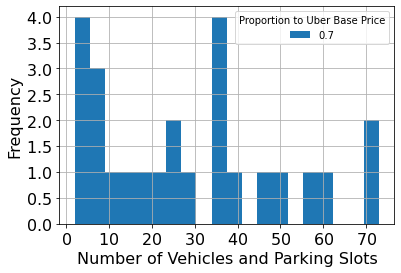

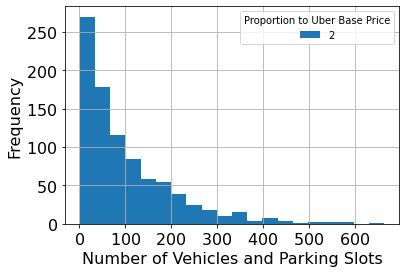

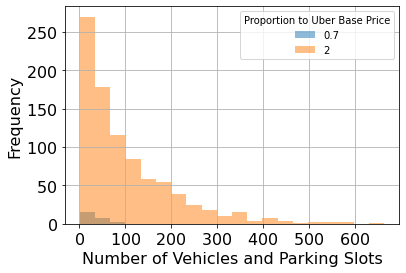

In [42]:
def prepareHistogram(dataFrame, xLabel, yLabel, legendTitle, fileName, amountBins=None, tickFormat=None, alpha=None):
    if amountBins is None:
        amountBins = 20
    if alpha is None:
        alpha = 1

    ax = dataFrame.plot.hist(bins=amountBins, alpha=alpha, grid=True)

    ax.legend(title=legendTitle)
    ax.set_xlabel(xLabel, fontsize=16)
    ax.set_ylabel(yLabel, fontsize=16)

    if tickFormat == 'plain':
        ax.ticklabel_format(useOffset=False, style='plain')
    else:
        ax.ticklabel_format(scilimits=(-5, 3), useMathText=True)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

dataFrame = pd.DataFrame(data=dataList, columns=['multiplier', 'distance', 'vehicles'])
dataFramePd = dataFrame.pivot(index='multiplier', columns='distance', values='vehicles')
#dataFramePd['multiplier'] = dataFrame.index
dataFramePd.sort_index(inplace=True)
#print(dataFramePd)
dataList = None

dfHistogram1 = pd.DataFrame(dataFramePd[500][0.7],
                            columns = [0.7])
fileName = folderSave / 'Histogram_Vehicles_500_07.eps'
ax = prepareHistogram(  dataFrame=dfHistogram1,
                        xLabel='Number of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20)

dfHistogram2 = pd.DataFrame(dataFramePd[500][2],
                            columns = [2])
fileName = folderSave / 'Histogram_Vehicles_500_2.eps'
ax = prepareHistogram(  dataFrame=dfHistogram2,
                        xLabel='Number of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20)

dfHistogram = pd.concat([dfHistogram1, dfHistogram2], axis=1, ignore_index=True)
dfHistogram.rename(columns={0: '0.7', 1: '2'}, inplace=True)
fileName = folderSave / 'Histogram_Vehicles_500_07_2.eps'
ax = prepareHistogram(  dataFrame=dfHistogram,
                        xLabel='Number of Vehicles and Parking Slots',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=20,
                        alpha=0.5)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

,all,0.7,2
count,40338.000000,2957.000000,22120.000000
mean,12.502112,6.996185,12.563055
std,16.007026,8.159138,15.602569
min,0.500068,0.504193,0.500068
25%,2.804227,1.916322,2.738525
50%,6.895904,4.500662,7.113950
75%,15.979090,8.921107,16.490508
max,263.890537,130.817405,263.890537


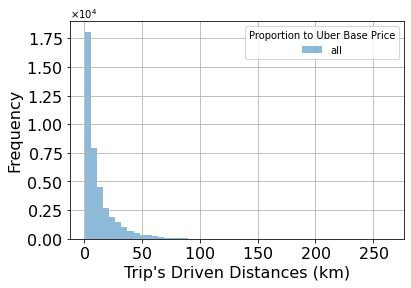

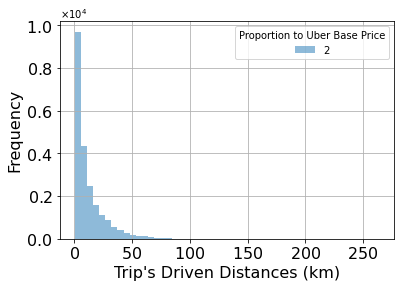

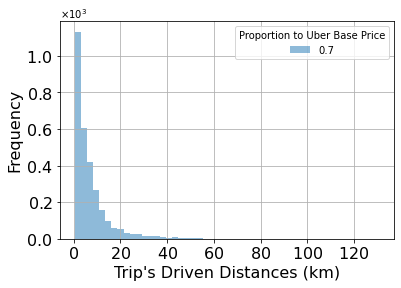

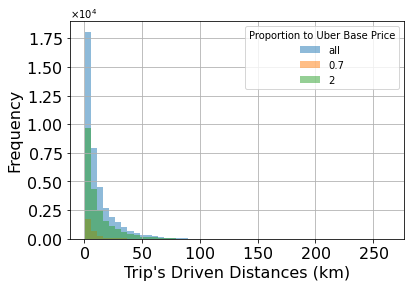

In [43]:
lengthAll = len(Trip.drivenDistances['all'])
length07 = len(Trip.drivenDistances[0.7])
length2 = len(Trip.drivenDistances[2])
Trip.drivenDistances[0.7].extend((lengthAll - length07) * [np.nan])
Trip.drivenDistances[2].extend((lengthAll - length2) * [np.nan])

dataFramePd = pd.DataFrame.from_dict(Trip.drivenDistances)
fileName = folderSave / 'Histogram_Distances_500_all.eps'
ax = prepareHistogram(  dataFrame=dataFramePd[['all']],
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

fileName = folderSave / 'Histogram_Distances_500_2.eps'
ax = prepareHistogram(  dataFrame=dataFramePd[[2]],
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

fileName = folderSave / 'Histogram_Distances_500_07.eps'
ax = prepareHistogram(  dataFrame=dataFramePd[[0.7]],
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

fileName = folderSave / 'Histogram_Distances_500_07_2_all.eps'
ax = prepareHistogram(  dataFrame=dataFramePd,
                        xLabel='Trip\'s Driven Distances (km)',
                        yLabel='Frequency',
                        legendTitle='Proportion to Uber Base Price',
                        fileName=fileName,
                        amountBins=50,
                        alpha=0.5)

dataFramePd.describe()

In [44]:
evaluatedMultipliers = [0.7, 2]
for pricesMultiplier in evaluatedMultipliers:    
    stationsBalance[pricesMultiplier].sort()
    i = 0
    while i < len(stationsBalance[pricesMultiplier]):
        currentStation = stationsBalance[pricesMultiplier][i][0]
        earlierBalance = stationsStart[pricesMultiplier][currentStation]

        while currentStation == stationsBalance[pricesMultiplier][i][0]:
            #Initially, idStation comes first to 
            (idStation, timestamp, vehiclesFlow) = stationsBalance[pricesMultiplier][i]
            stationsBalance[pricesMultiplier][i] = (timestamp, idStation, 100*vehiclesFlow/stationsStart[pricesMultiplier][currentStation], earlierBalance)
            earlierBalance += vehiclesFlow
            i += 1

    dataFramePd = pd.DataFrame(stationsBalance[pricesMultiplier], columns=['timestamp', 'station', 'pctbalance', 'balance'])
    dataFramePd = dataFramePd.set_index('timestamp')
    dataFramePd[['pctbalance']].plot()

KeyError: 1

In [ ]:
def prepareBarPlot(dictOfDataToPlot, dataForIndexing, translateKeys, sortedIndex,
                    xLabel, yLabel, fileName, xTicks=None, yTicks=None, yLim=[0, None], legendTitle=None, legendLocation='best', ax=None, zorder=None):
    dataFramePd = pd.DataFrame.from_dict(dictOfDataToPlot)
    dataFramePd.index = dataForIndexing
    dataFramePd = dataFramePd.rename(index=translateKeys)
    dataFramePd = dataFramePd.reindex(sortedIndex)

    ax = dataFramePd.plot.bar(fontsize=16, grid=True, ax=ax, zorder=zorder)
    handles, labels = ax.get_legend_handles_labels()
    legendObject = ax.legend(handles, labels, title=legendTitle, loc=legendLocation)

    ax.set_xlabel(xLabel, fontsize=16)
    ax.set_ylabel(yLabel, fontsize=16)

    ax.set_ylim(yLim)

    if xTicks is not None:
        ax.set_xticks(xTicks)
    if yTicks is not None:
        ax.set_yticks(yTicks)
    
    plt.savefig(fileName, format='eps', bbox_inches="tight")
    #plt.show()

    return ax

def initDictMultiplierPercentages(evaluatedMultipliers):
    return {pricesMultiplier: list() for pricesMultiplier in evaluatedMultipliers}

def setDictionaries(dictPeople, dictServed, dictSharePeople, dictPercentageServed, dictSharedServed, evaluatedMultipliers):
    totalPeople = sum(dictPeople.values())
    for key, value in dictPeople.items():
        dictSharePeople[key] = 100*value/totalPeople

    for pricesMultiplier in evaluatedMultipliers:
        totalServedMultiplier = sum(dictServed[pricesMultiplier].values())
        for key, value in dictPeople.items():
            dictPercentageServed[pricesMultiplier].append(100*dictServed[pricesMultiplier][key]/value)
            dictSharedServed[pricesMultiplier].append(100*dictServed[pricesMultiplier][key]/totalServedMultiplier)

def getSortedKeys(dictSharePeople, translateKeys):
    #Renaming keys
    sortedKeysPeople = list()
    for key, value in translateKeys.items():
        if key in dictSharePeople:
            dictSharePeople[value] = [dictSharePeople.pop(key)]
            sortedKeysPeople.append(value)
    sortedKeysPeople = sorted(sortedKeysPeople, key=lambda x: dictSharePeople[x][0], reverse=True)

    return sortedKeysPeople

def getDataFrameSortedIndex(dictSharePeople, sortedKeysPeople):
    dataFramePd = pd.DataFrame.from_dict(dictSharePeople, orient='index', columns=['Actual share of demand'])
    dataFramePd = dataFramePd.reindex(sortedKeysPeople)

    return dataFramePd

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


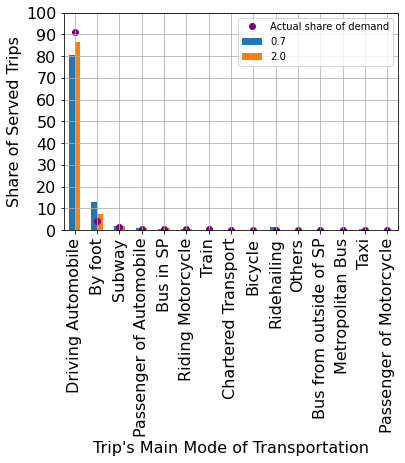

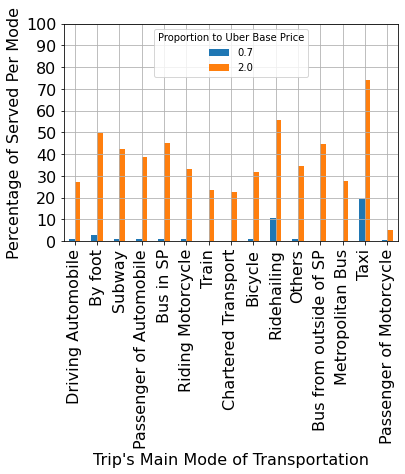

In [ ]:
translateModes = {  1: 'Subway',
                    2: 'Train',
                    3: 'Monorail',
                    4: 'Bus in SP',
                    5: 'Bus from outside of SP',
                    6: 'Metropolitan Bus',
                    7: 'Chartered Transport',
                    8: 'Student\'s Transport',
                    9: 'Driving Automobile',
                    10: 'Passenger of Automobile',
                    11: 'Taxi',
                    12: 'Ridehailing',
                    13: 'Riding Motorcycle',
                    14: 'Passenger of Motorcycle',
                    15: 'Bicycle',
                    16: 'By foot',
                    17: 'Others'}

Trip.sharePeopleMainMode = dict()
Trip.percentageServedMainMode = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedMainMode = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleMainMode,
                dictServed=Trip.amountServedMainMode,
                dictSharePeople=Trip.sharePeopleMainMode,
                dictPercentageServed=Trip.percentageServedMainMode,
                dictSharedServed=Trip.shareServedMainMode,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleMode = getSortedKeys(dictSharePeople=Trip.sharePeopleMainMode, translateKeys=translateModes)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleMainMode, sortedKeysPeople=sortedKeysPeopleMode)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / 'Share_Served_Trips.eps'
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedMainMode,
                    dataForIndexing=list(Trip.amountPeopleMainMode.keys()),
                    translateKeys=translateModes,
                    sortedIndex=sortedKeysPeopleMode,
                    xLabel='Trip\'s Main Mode of Transportation',
                    yLabel='Share of Served Trips',
                    yLim=[0, 100],
                    yTicks=range(0, 110, 10),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / 'Percentage_Served_Per_Mode.eps'
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedMainMode,
                    dataForIndexing=list(Trip.amountPeopleMainMode.keys()),
                    translateKeys=translateModes,
                    sortedIndex=sortedKeysPeopleMode,
                    xLabel='Trip\'s Main Mode of Transportation',
                    yLabel='Percentage of Served Per Mode',
                    yLim=[0, 100],
                    yTicks=range(0, 110, 10),
                    legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


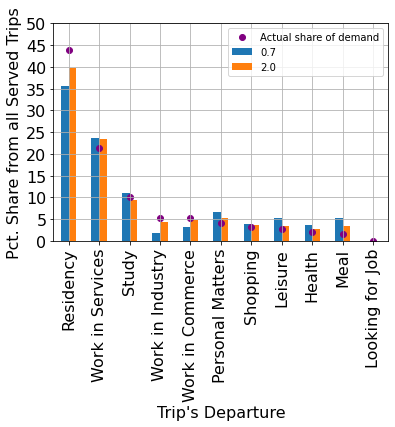

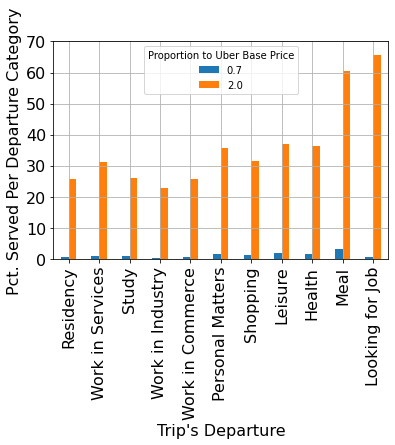

In [ ]:
translateReasons = {1: 'Work in Industry',
                    2: 'Work in Commerce',
                    3: 'Work in Services',
                    4: 'Study',
                    5: 'Shopping',
                    6: 'Health',
                    7: 'Leisure',
                    8: 'Residency',
                    9: 'Looking for Job',
                    10: 'Personal Matters',
                    11: 'Meal'}

Trip.sharePeopleDepartureReason = dict()
Trip.percentageServedDepartureReason = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedDepartureReason = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleDepartureReason,
                dictServed=Trip.amountServedDepartureReason,
                dictSharePeople=Trip.sharePeopleDepartureReason,
                dictPercentageServed=Trip.percentageServedDepartureReason,
                dictSharedServed=Trip.shareServedDepartureReason,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleReason = getSortedKeys(dictSharePeople=Trip.sharePeopleDepartureReason, translateKeys=translateReasons)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleDepartureReason, sortedKeysPeople=sortedKeysPeopleReason)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / 'Share_Served_Departure_Category.eps'
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedDepartureReason,
                    dataForIndexing=list(Trip.amountPeopleDepartureReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure',
                    yLabel='Pct. Share from all Served Trips',
                    yLim=[0, 50],
                    yTicks=range(0, 55, 5),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / 'Percentage_Served_Per_Departure_Category.eps'
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedDepartureReason,
                    dataForIndexing=list(Trip.amountPeopleDepartureReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure',
                    yLabel='Pct. Served Per Departure Category',
                    yLim=[0, 70],
                    yTicks=range(0, 80, 10),
                    legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


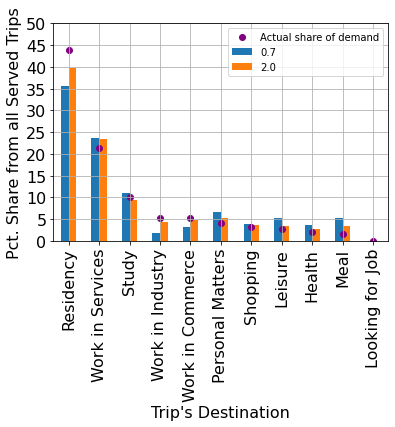

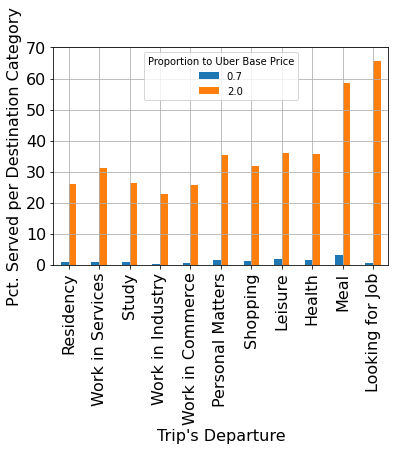

In [ ]:
Trip.sharePeopleDestinationReason = dict()
Trip.percentageServedDestinationReason = initDictMultiplierPercentages(evaluatedMultipliers)
Trip.shareServedDestinationReason = initDictMultiplierPercentages(evaluatedMultipliers)
setDictionaries(dictPeople=Trip.amountPeopleDestinationReason,
                dictServed=Trip.amountServedDestinationReason,
                dictSharePeople=Trip.sharePeopleDestinationReason,
                dictPercentageServed=Trip.percentageServedDestinationReason,
                dictSharedServed=Trip.shareServedDestinationReason,
                evaluatedMultipliers=evaluatedMultipliers)

sortedKeysPeopleReason = getSortedKeys(dictSharePeople=Trip.sharePeopleDestinationReason, translateKeys=translateReasons)

dataFramePd = getDataFrameSortedIndex(dictSharePeople=Trip.sharePeopleDestinationReason, sortedKeysPeople=sortedKeysPeopleReason)
ax = dataFramePd.plot(color='purple', marker='o', linestyle='None', zorder=1)

fileName = folderSave / 'Share_Served_Destination_Category.eps'
ax = prepareBarPlot(dictOfDataToPlot=Trip.shareServedDestinationReason,
                    dataForIndexing=list(Trip.amountPeopleDestinationReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Destination',
                    yLabel='Pct. Share from all Served Trips',
                    yLim=[0, 50],
                    yTicks=range(0, 55, 5),
                    fileName=fileName,
                    ax=ax,
                    zorder=0)

fileName = folderSave / 'Percentage_Served_Per_Destination_Category.eps'
ax = prepareBarPlot(dictOfDataToPlot=Trip.percentageServedDestinationReason,
                    dataForIndexing=list(Trip.amountPeopleDestinationReason.keys()),
                    translateKeys=translateReasons,
                    sortedIndex=sortedKeysPeopleReason,
                    xLabel='Trip\'s Departure',
                    yLabel='Pct. Served per Destination Category',
                    yLim=[0, 70],
                    yTicks=range(0, 80, 10),
                    legendTitle='Proportion to Uber Base Price',
                    legendLocation='upper center',
                    fileName=fileName)